# Import Data

First, we are going to import a small subset of the total data for exploratory data analysis. We are only interested in the tweets written in English.

In [2]:
# Import Packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re

In [4]:
# Import all data
IRA_csv = pd.read_csv("Data/IRAhandle_tweets_1.csv")

# Select tweets in English
df = IRA_csv.copy()[IRA_csv['language'] == "English"]

# Convert date
df['publish_date'] = pd.to_datetime(df['publish_date'])

# Set index to date + sort
#df.set_index('publish_date', inplace = True)
#df.sort_index(inplace=True)

In [24]:
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1,updates1000ma
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,10/1/2017 19:59,1052,9636,253,...,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,10/1/2017 22:43,1054,9637,254,...,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,10/1/2017 22:51,1054,9637,255,...,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,10/1/2017 23:52,1062,9642,256,...,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,10/1/2017 2:13,1050,9645,246,...,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN,NaN


In [6]:
# Rolling mean columns for plotting
df['updates1000ma'] = df['updates'].rolling(1000).mean()

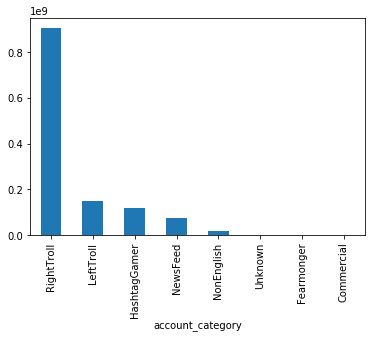

In [9]:
df_cat_updates = df.groupby('account_category')['updates'].sum().sort_values(ascending=False)

cat_plot = df_cat_updates.plot.bar()

In [12]:
accounts_max = df.groupby(['account_category', 'author']).max()

In [13]:
accounts_max.describe()

,alt_external_id,external_author_id,followers,following,new_june_2018,retweet,tweet_id,updates,updates1000ma
count,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000,249.000000,2.490000e+02,249.000000,242.000000
mean,3.024771e+17,3.025013e+17,705.257028,981.393574,0.285141,0.823293,7.740919e+17,2263.919679,2846.948756
std,4.179341e+17,4.179680e+17,2273.605614,1991.073836,0.452391,0.382189,1.074534e+17,5652.591184,4147.643087
min,3.497640e+07,3.497640e+07,0.000000,0.000000,0.000000,0.000000,5.985325e+17,3.000000,279.069000
25%,2.176657e+09,2.176657e+09,51.000000,60.000000,0.000000,1.000000,6.717084e+17,336.000000,605.197000
50%,2.592433e+09,2.592433e+09,135.000000,284.000000,0.000000,1.000000,7.459857e+17,630.000000,1095.400500
75%,8.886125e+17,8.890000e+17,448.000000,1026.000000,1.000000,1.000000,8.920644e+17,2526.000000,2837.674500
max,9.058747e+17,9.060000e+17,23890.000000,21843.000000,1.000000,1.000000,9.766389e+17,69979.000000,38562.113000


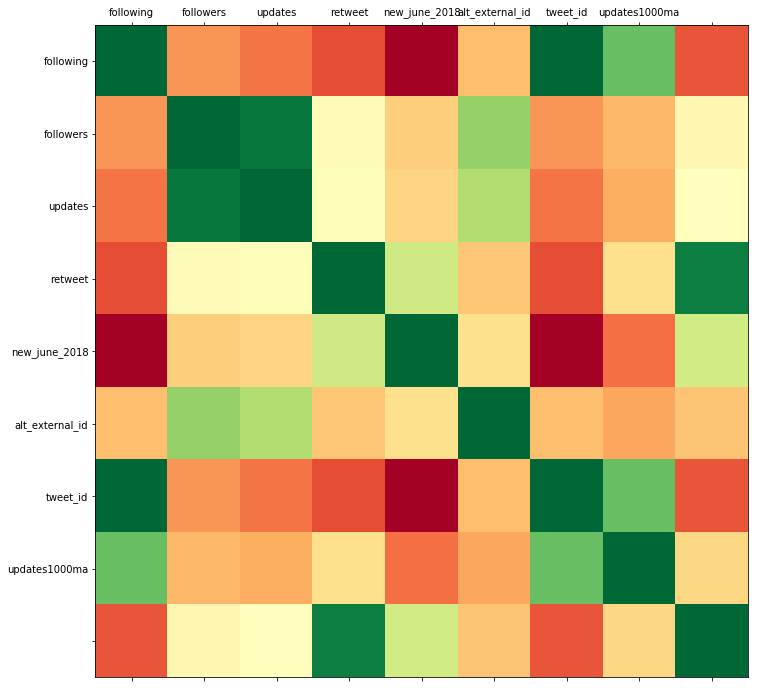

In [15]:
# Drop irrelevant/string columns first + incorporate sentiment
df_corr = df.corr()

labels = [c for c in df_corr.columns]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.matshow(df_corr, cmap=plt.cm.RdYlGn)


## Tweets by Category

In [16]:
# Define count_entries()
def count_entries(df, *args):
    """Return a dictionary with counts of
    occurrences as value for each key."""
    
    #Initialize an empty dictionary: cols_count
    cols_count = {}
    
    # Iterate over column names in args
    for col_name in args:
    
        # Extract column from DataFrame: col
        col = df[col_name]
    
        # Iterate over the column in DataFrame
        for entry in col:
    
            # If entry is in cols_count, add 1
            if entry in cols_count.keys():
                cols_count[entry] += 1
    
            # Else add the entry to cols_count, set the value to 1
            else:
                cols_count[entry] = 1

    # Return the cols_count dictionary
    return cols_count

# Call count_entries(): result
cat_count = count_entries(df, 'account_category')

cat_count

{'RightTroll': 113335,
 'Fearmonger': 378,
 'NonEnglish': 2139,
 'LeftTroll': 35494,
 'Unknown': 580,
 'HashtagGamer': 26720,
 'NewsFeed': 11269,
 'Commercial': 337}

# Basic Visualizations

Not all of the tweets in this dataset are in English. For the purposes of this project, we are only interested in the English tweets.

# Network Analysis

We are interested in the structure of the social network within which these accounts reside. 

From this dataset, we are only able to create a **mentions network**, since we do not have data regarding who has retweeted these tweets. In particular, we are intereset in which IRA accounts mention other IRA accounts, and how often. 

First, we need to create a function which uses regular expressions to extract the Twitter handles mentioned in each tweet. 

Then, we will create a function to construct a graph of mentions. This will be a directed graph, where each node represent an IRA account and each edge represents a direct mention.

In [25]:
# Create test data
test_tweets = df[['external_author_id', 'author',str('content')]].sample(50, random_state=345)
test_tweets

,external_author_id,author,content
139183,895000000000000000,ANASTASSITR,#anata How Did Susan Rice Make MILLIONS Workin...
106037,1679279490,AMELIEBALDWIN,"U @lyndell_evans love Jews, providing they're ..."
221958,1671936266,ARM_2_ALAN,Trump Sets Up Hotline For Veterans To Call To ...
226996,895000000000000000,ARTEMSSFE,Is Flynn's Unmasking McCabe's Revenge? https:/...
240628,2944766250,ATLANTA_ONLINE,Top 5 signature moments of Roddy White’s caree...
153381,2878166306,ANDYHASHTAGGER,#ThingsIWontTellMyDad that I did end marrying ...
24183,1652138929,ACEJINEV,".@DavidVargyas Also, you're commenting on the ..."
219378,1671936266,ARM_2_ALAN,#local 4 Charged in Canaryville Double-Stabbing
9323,3312143142,4MYSQUAD,'@Bethenny LOL'
198547,1672104320,AN_N_GASTON,My bed is more attractive than most people


In [32]:
# NEED TO CREATE FUNTCIONALITY TO SEPARATE EACH MULTI_MENTION
#^^^ be sure to drop tweets where retweet == 1'''

#This function works for one tweet, but not for a list of tweets:
def extract_usernames(tweet_content):
    drop_emails = re.sub("[\w]+@[\w]+\.[c][o][m]", "", tweet_content)
    mentioned_users = re.findall("@([a-zA-Z0-9]{1,15})", drop_emails)
    return mentioned_users

test_tweets['mentioned'] = test_tweets['content'].apply(extract_usernames)

tweet_dict = dict(zip(test_tweets['author'], test_tweets['mentioned']))
tweet_dict

{'ANASTASSITR': [],
 'AMELIEBALDWIN': [],
 'ARM_2_ALAN': ['mark85nh', 'NatShupe'],
 'ARTEMSSFE': [],
 'ATLANTA_ONLINE': [],
 'ANDYHASHTAGGER': [],
 'ACEJINEV': [],
 '4MYSQUAD': ['Bethenny'],
 'AN_N_GASTON': [],
 'ANTONRUMSS': [],
 'AMANDAVGREEN': [],
 'AMALIA_PETTY': [],
 'AFEELIUTR': [],
 'ADDIE_HOL': [],
 'ALIISTRR': [],
 'ADNNELSTR': [],
 'ANAALESSIS': [],
 'AANTIRACIST': [],
 'ASHLEEYWES': [],
 'ALECMOOOOODY': ['FAMU'],
 'ANDYDREWDANIELS': [],
 'ANISACRRUTR': [],
 'ALANISSTRS': [],
 'ARABMTR': [],
 'ARKADII_TROFIM': [],
 'ANNIEPOSHES': []}

In [45]:
IRA_authors = df['author'].unique()


# Function to create user mentions
def ira_mentions_graph(mentions, accounts_of_interest):
    """Extracts a list of unique tweet-posters from dataset. Reads tweets, and returns graph
    where nodes are tweet-posters and edges are mentions of other IRA tweet-posters. Weight of edges
    correspond to frequency of mentions
    """
    
    g = nx.DiGraph() # Directed graph
    counter = 0
    user_names= {}
    
    for k, v in mentions.items():
        if v in accounts_of_interest and user_names
            
            
            
        '''counter += 1
        tweet_poster = int(tweets['external_author_id']
        
        if user_names.has_key(tweet_poster) and not tweets['author'] in user_names[tweet_poster]:
            user_names[tweet_poster].append(tweets['author'])
            
        else:
            user_names[tweet_poster] = tweets['author'] 
    
                           
        # Iterate through mentioned users - DOES THIS NEED TO BE DONE BEFOREHAND IN SEP FXN?
        mentions = tweets[]
        
        '''
        
ira_mentions_graph(tweet_dict)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


In [36]:
tweet_dict.items()

dict_items([('ANASTASSITR', []), ('AMELIEBALDWIN', []), ('ARM_2_ALAN', ['mark85nh', 'NatShupe']), ('ARTEMSSFE', []), ('ATLANTA_ONLINE', []), ('ANDYHASHTAGGER', []), ('ACEJINEV', []), ('4MYSQUAD', ['Bethenny']), ('AN_N_GASTON', []), ('ANTONRUMSS', []), ('AMANDAVGREEN', []), ('AMALIA_PETTY', []), ('AFEELIUTR', []), ('ADDIE_HOL', []), ('ALIISTRR', []), ('ADNNELSTR', []), ('ANAALESSIS', []), ('AANTIRACIST', []), ('ASHLEEYWES', []), ('ALECMOOOOODY', ['FAMU']), ('ANDYDREWDANIELS', []), ('ANISACRRUTR', []), ('ALANISSTRS', []), ('ARABMTR', []), ('ARKADII_TROFIM', []), ('ANNIEPOSHES', [])])

In [ ]:
'''
I'm struggling to translate my preference for pipes into python. Here's a simple psuedo-code example:

for tweet in dataset:
    user_mentions = drop_emails_fxn(tweet) %>%
                    extract_usernames_fxn(tweet)
        
I want to drop emails from the tweet first, THEN extract the usernames. In Python, don't I have to use separate variables?

for tweet in dataset:
    no_emails = drop_emails_fxn(tweet)
    user_mentions = extract_usernames_fxn(tweet)
'''

# Key Influencers 

We can see that there are a few accounts which stand out as being influential. What are their common characteristics?

# Credibility Score 



# Sentiment Analysis

Previous studies have show that influential Twitter accounts tend to have a distinct sentiment 

# Things to Investigate / Incorporate

    Strong postive correlation between followers - following.
    
    There is a hashtagger account named "Andy Hashtagger"
    
    1. Create new features
        a. botometer score of mentioned accts which are still active
        b. sentiment score of tweets
        c. some ratio of followers/following/participation
    2. Use these features to predict updates
    
    What states do these people list in their bio? Does that correlate with anything?